In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from helpers.interpolate_extinction_coeffs import extinction_coeffs

In [3]:
wls, (water_ex, oxy_ex, deoxy_ex, lipid_ex) = extinction_coeffs()

with pm.Model() as skin_scalp:
    blood = pm.Uniform('blood', lower=1, upper=100)
    blood_sat = pm.Beta('blood_sat', alpha=2, beta=5)
    oxy = pm.Deterministic('oxy', blood_sat*blood)
    deoxy = pm.Deterministic('deoxy', (1 - blood_sat)*blood)

    lw_frac = pm.Beta('LW_frac', alpha=2, beta=5)
    w_over_lw_frac = pm.Beta('water_over_lipid_frac', alpha=2, beta=2)
    water_frac = pm.Deterministic('water_frac', lw_frac*w_over_lw_frac)
    lipid_frac = pm.Deterministic('lipid_frac', w_over_lw_frac - water_frac)
    m = pm.Uniform('m', lower=2.5, upper=3.5)
    mel_frac = pm.Uniform('mel_frac', lower=0, upper=0.025)
    
    mel_abs = pm.Deterministic('mel_abs', 519*mel_frac*(wls / 500)**(-m))
    water_abs = pm.Deterministic('water_abs', water_frac*55.5*water_ex)
    oxy_abs = pm.Deterministic('oxy_abs', oxy*oxy_ex*1e-6)
    deoxy_abs = pm.Deterministic('deoxy_abs', deoxy*deoxy_ex*1e-6)
    lipid_abs = pm.Deterministic('lipid_abs', lipid_frac*lipid_ex)
    absorption = pm.Deterministic('absorption',
        water_abs + oxy_abs + deoxy_abs + lipid_abs + mel_abs
    )

    a = pm.Uniform('a', lower=5, upper=60)
    b = pm.Uniform('b', lower=0.2, upper=3)

    scattering = pm.Deterministic('scattering',
        a*(wls/500.0)**(-b)
    )

In [4]:
with skin_scalp:
    prior = pm.sample_prior_predictive(samples=100)

Sampling: [LW_frac, a, b, blood, blood_sat, m, mel_frac, water_over_lipid_frac]


total absorption


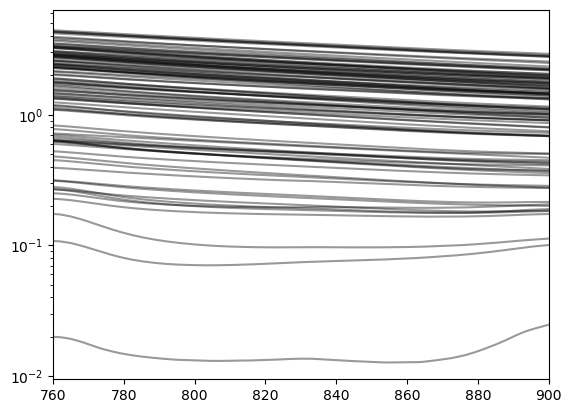

individual absorption


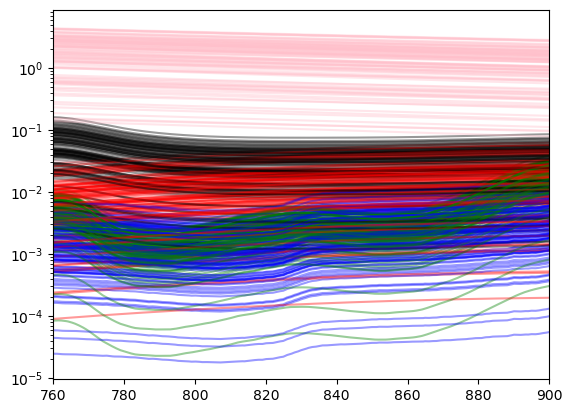

scattering


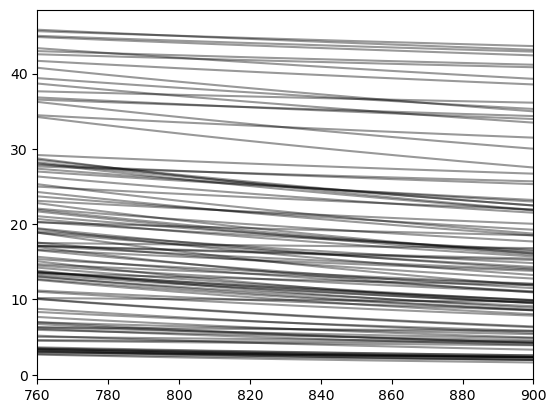

In [5]:
wl_range = (760, 900)
prior_abs = prior['prior'].absorption[0, ...]

print('total absorption')
plt.figure()
for row in prior_abs:
    plt.plot(wls, row, color='black', alpha=0.4)

plt.yscale('log')
plt.xlim(wl_range)
plt.show()

print('individual absorption')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].water_abs[0, i, :], color='blue', alpha=0.4)
    plt.plot(wls, prior['prior'].oxy_abs[0, i, :], color='red', alpha=0.4)
    plt.plot(wls, prior['prior'].deoxy_abs[0, i, :], color='black', alpha=0.4)
    plt.plot(wls, prior['prior'].lipid_abs[0, i, :], color='green', alpha=0.4)
    plt.plot(wls, prior['prior'].mel_abs[0, i, :], color='pink', alpha=0.4)
plt.xlim(wl_range)
plt.yscale('log')
plt.show()

print('scattering')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].scattering[0, i, :], color='black', alpha=0.4)
plt.xlim(wl_range)
plt.show()

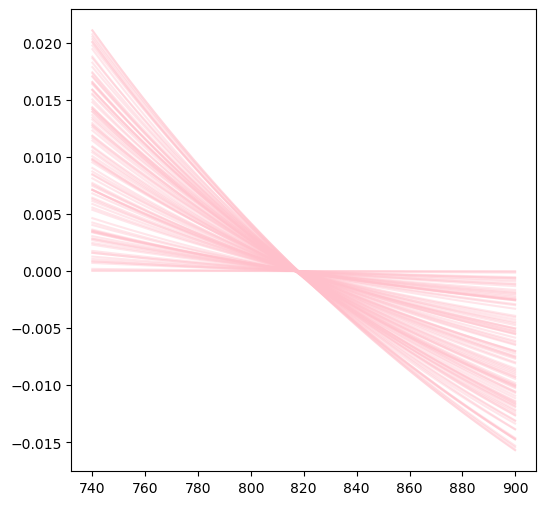

In [8]:
# error in ignoring melanin

plt.figure(figsize=(6,6))

L = 0.02

for i in prior['prior'].draw:
    mel_abs = prior['prior'].mel_abs[0, i, :]
    diff = mel_abs - np.mean(mel_abs)
    error = diff*L
    plt.plot(wls, error, color='pink', alpha=0.4)

plt.show()